(dims_module)=

# PyMC dims module

## A short history of dims in PyMC

PyMC introduced the ability to specify model variable `dims` in version 3.9 in June 2020 (5 years as of the time of writing). In the release notes, it was mentioned only after [14 other new features](https://github.com/pymc-devs/pymc/blob/1d00f3eb81723523968f3610e81a0c42fd96326f/RELEASE-NOTES.md?plain=1#L236), but over time it became a foundation of the library.

It allows users to more naturally specify the dimensions of model variables with string names, and provides a "seamless" conversion to arviz {doc}`InferenceData <arviz:xarray_for_arviz>` objects, which have become the standard for storing and investigating results from probabilistic programming languages.

However, the behavior of dims is rather limited. It can only be used to specify the shape of new random variables and label existing dimensions (e.g., in {func}`~pymc.Deterministic`). Otherwise it has no effect on the computation, unlike operations done with {class}`~arviz.InferenceData` variables, which are based on {lib}`xarray` and where dims inform array selection, alignment, and broadcasting behavior.

As a result, in PyMC models users have to write computations that follow NumPy semantics, which often requires transpositions, reshapes, new axis (`None`) and numerical axis arguments sprinkled everywhere. It can be hard to get these right and in the end it's often hard to make sense of the written model.

### Expanding the role of dims

Now we are introducing an experimental {mod}`pymc.dims` module that allows users to define data, distributions, and math operations that respect dim semantics, following {mode}`xarray` operations **without coordinates** as closely as possible.

:::{warning}The `dims` module is experimental, not exhaustively tested and the API is being iteratively worked on, and is therefore subject to changes between any two PyMC releases. We welcome users to test it and provide feedback, but we don't yet endorse its use for production.:::


## A simple example

We'll start with a model written in current PyMC style, using synthetic data.

In [1]:
import numpy as np

import pymc as pm

seed = sum(map(ord, "dims module"))
rng = np.random.default_rng(seed)

In [2]:
# Very realistic looking data!
observed_response_np = np.ones((5, 20), dtype=int)
coords = coords = {
    "participant": range(5),
    "trial": range(20),
    "item": range(3),
}

This model predicts participants' categorical responses across trials by combining participant-specific item preferences (constrained to sum to zero) with shared time-varying effects, then applying a softmax to model response probabilities.

Notice the need to identify axes by number rather than dimension name, and the need to use `None` to create new axes in order to specify broadcast requirements.

In [3]:
with pm.Model(coords=coords) as model:
    observed_response = pm.Data(
        "observed_response", observed_response_np, dims=("participant", "trial")
    )
    # Use ZeroSumNormal to avoid identifiability issues
    participant_preference = pm.ZeroSumNormal(
        "participant_preference", n_zerosum_axes=1, dims=("participant", "item")
    )

    # Shared time effects across all participants
    time_effects = pm.Normal("time_effects", dims=("trial", "item"))

    trial_preference = pm.Deterministic(
        "trial_preference",
        participant_preference[:, None, :] + time_effects[None, :, :],
        dims=("participant", "trial", "item"),
    )

    response = pm.Categorical(
        "response",
        p=pm.math.softmax(trial_preference, axis=-1),
        observed=observed_response,
        dims=("participant", "trial"),
    )

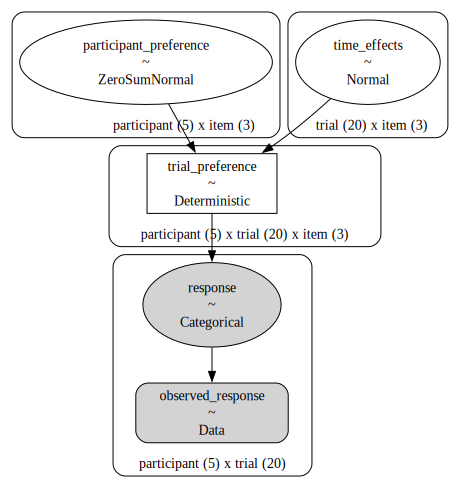

In [4]:
model.to_graphviz()

And here's the equivalent model using the {mod}`pymc.dims` module.

In [5]:
import pymc.dims as pmd

/home/ricardo/Documents/pymc/pymc/dims/__init__.py:66: UserWarning: The `pymc.dims` module is experimental and may contain critical bugs (p=0.676).
Please report any issues you encounter at https://github.com/pymc-devs/pymc/issues.
Disclaimer: This an experimental API and may change at any time.
  __init__()


In [6]:
with pm.Model(coords=coords) as dmodel:
    observed_response = pmd.Data(
        "observed_response", observed_response_np, dims=("participant", "trial")
    )
    participant_preference = pmd.ZeroSumNormal(
        "participant_preference", core_dims="item", dims=("participant", "item")
    )

    # Shared time effects across all participants
    time_effects = pmd.Normal("time_effects", dims=("item", "trial"))

    trial_preference = pmd.Deterministic(
        "trial_preference",
        participant_preference + time_effects,
    )

    response = pmd.Categorical(
        "response",
        p=pmd.math.softmax(trial_preference, dim="item"),
        core_dims="item",
        observed=observed_response,
    )

Note we still use the same {class}`~pymc.Model` constructor, but everything else was now defined with an equivalent function or class defined in the {mod}`pymc.dims` module.

There are some notable differences:

1. `ZeroSumNormal` takes a `core_dims` argument instead of `n_zerosum_axes`. This tells PyMC which of the `dims` that define the distribution are constrained to be zero-summed. All distributions that take non-scalar parameters now require a `core_dims` argument. Previously, they were assumed to be right-aligned by the user (see more in {doc}`dimensionality`). Now you don't have to worry about the order of the dimensions in your model, just their meaning!

2. The `trial_preference` computation aligns dimensions for broadcasting automatically. Note we use {func}`pymc.dims.Deterministic` and not {func}`pymc.Deterministic`, which automatically propagates the `dims` to the model object.

3. The `softmax` operation specifies the `dim` argument, not the positional axis. Note: The parameter is called `dim` and not `core_dims` because we try to stay as close as possible to the Xarray API, which uses `dim` throughout. But we make an exception for distributions because they already have the `dims` argument.

4. The `Categorical` observed variable, like `ZeroSumNormal`, requires a `core_dims` argument to specify which dimension corresponds to the probability vector. Previously, it was necessary to place this dimension explicitly on the rightmost axis -- not any more!

5. Even though dims were not specified for either `trial_preference` or `response`, PyMC automatically infers them.

The graphviz representation looks the same as before.

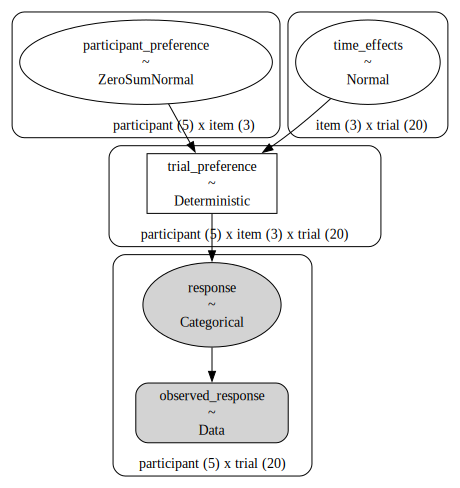

In [7]:
dmodel.to_graphviz()

We can also check that the models are equivalent by comparing the `logp` of each variable evaluated at the initial_point.

In [8]:
print(model.point_logps())
print(dmodel.point_logps())

{'participant_preference': np.float64(-9.19), 'time_effects': np.float64(-55.14), 'response': np.float64(-109.86)}
{'participant_preference': np.float64(-9.19), 'time_effects': np.float64(-55.14), 'response': np.float64(-109.86)}


## A brief look under the hood

The {mod}`pymc.dims` module functionality is built on top of the experimental {mod}`pytensor.xtensor` module in PyTensor, which is the {lib}`xarray` analogoue of the {mod}`pytensor.tensor` module you may be familiar with (see {doc}`pymc_and_pytensor`).

Whereas regular distributions and math operations return {class}`~pytensor.tensor.TensorVariable` objects, the corresponding functions in the {mod}`pymc.dims` module returns {class}`~pytensor.xtensor.type.XTensorVariable` objects. These are very similar to {class}`~pytensor.tensor.TensorVariable`, but they have a `dims` attribute that determines their behavior.

As an example, we'll create a regular {class}`~pymc.Normal` random variable with 3 elements, and perform an outer addition on them using NumPy syntax.

In [9]:
regular_normal = pm.Normal.dist(mu=pm.math.as_tensor([0, 1, 2]), sigma=1, shape=(3,))
regular_normal.type

TensorType(float64, shape=(3,))

In [10]:
type(regular_normal)

pytensor.tensor.variable.TensorVariable

In [11]:
outer_addition = regular_normal[:, None] + regular_normal[None, :]
outer_addition.type

TensorType(float64, shape=(3, 3))

In [12]:
pm.draw(outer_addition, random_seed=rng)

array([[0.61284312, 1.68384684, 1.72225487],
       [1.68384684, 2.75485056, 2.79325859],
       [1.72225487, 2.79325859, 2.83166662]])

Here's the same operation with a dimmed `Normal` variable. It requires the use of `rename`.

In [13]:
dims_normal = pmd.Normal.dist(mu=pmd.math.as_xtensor([0, 1, 2], dims=("a",)), sigma=1)
dims_normal.type

XTensorType(float64, shape=(3,), dims=('a',))

In [14]:
type(dims_normal)

pytensor.xtensor.type.XTensorVariable

In [15]:
outer_addition = dims_normal + dims_normal.rename({"a": "b"})
outer_addition.type

XTensorType(float64, shape=(3, 3), dims=('a', 'b'))

In [16]:
pm.draw(outer_addition, random_seed=rng)

array([[ 3.76355516,  0.31059132,  6.5420105 ],
       [ 0.31059132, -3.14237253,  3.08904666],
       [ 6.5420105 ,  3.08904666,  9.32046584]])

:::{tip} Note that there are no coordinates anywhere in the graph. {class}`~pytensor.xtensor.type.XTensorVariable`s behave like xarray DataArrays **without** coords. Dims determine the dimension meaning and alignment, but no extra work can be done to reason within a dim. We discuss this limitation in more detail at the end.:::

## Redundant (or implicit) dims

When defining deterministic operations or creating variables whose dimension are all implied by the parameters, there's no need to specify the `dims` argument, as PyMC will automatically know them.

However, some users might want to specify `dims` anyway, to check that the dimensions of the variables are as expected, or to provide type hints for someone reading the model.

PyMC allows specifying dimensions in these cases. To reduce confusion, the output will always be transposed to be aligned with the user-specified dims.

In [17]:
with pm.Model(coords={"a": range(2), "b": range(5)}) as example:
    x = pmd.Normal("x", dims=("a", "b"))
    det_implicit_dims = pmd.Deterministic("det1", x + 1)
    det_explicit_dims = pmd.Deterministic("det2", x + 1, dims=("a", "b"))
    det_transposed_dims = pmd.Deterministic("y", x + 1, dims=("b", "a"))

print(f"{det_implicit_dims.dims=}")
print(f"{det_explicit_dims.dims=}")
print(f"{det_transposed_dims.dims=}")

det_implicit_dims.dims=('a', 'b')
det_explicit_dims.dims=('a', 'b')
det_transposed_dims.dims=('b', 'a')


This happens with `Deterministic`, `Potential` and every distribution in the `dims` module.
Any time you specify `dims`, you will get back a variable with dimensions in the same order.

Furthermore -- and unlike regular PyMC objects -- it is now valid to use ellipsis in the `dims` argument.
As in an Xarray `transpose`, it means all the other dimensions should stay in the same order.

In [18]:
with pm.Model(coords={"a": range(2), "b": range(5)}) as example:
    x = pmd.Normal("x", dims=("a", "b"))
    det_ellipsis1 = pmd.Deterministic("det1", x + 1, dims=(...,))
    det_ellipsis2 = pmd.Deterministic("det2", x + 1, dims=(..., "a"))
    det_ellipsis3 = pmd.Deterministic("det3", x + 1, dims=("b", ...))

print(f"{det_ellipsis1.dims=}")
print(f"{det_ellipsis2.dims=}")
print(f"{det_ellipsis3.dims=}")

det_ellipsis1.dims=('a', 'b')
det_ellipsis2.dims=('b', 'a')
det_ellipsis3.dims=('b', 'a')


## What functionality is supported?

The documentation is still a work in progress, and there is no complete list of distributions and operations that are supported just yet. 

#### Model constructors

The following PyMC model constructors are available in the `dims` module.

  * {func}`~pymc.dims.Data`
  * {func}`~pymc.dims.Deterministic`
  * {func}`~pymc.dims.Potential`

They all return {class}`~pytensor.xtensor.type.XTensorVariable` objects, and either infer `dims` from the input or require the user to specify them explicitly. If they can be inferred, it is possible to transpose and use ellipsis in the `dims` argument, as described above.

#### Distributions

We want to offer all the existing distributions and parametrizations under the {mod}`pymc.dims` module, with the following expected API differences:

 * All vector arguments (and observed values) must have known dims. An error is raised otherwise.

 * Distributions with non-scalar inputs will require a `core_dims` argument. The meaning of the `core_dims` argument will be denoted in the docstrings of each distribution. For example, for the MvNormal, the `core_dims` are the two dimensions of the covariance matrix, one (and only one) of which must also be present in the mean parameter. The shared `core_dim` is the one that persists in the output. Sometimes the order of `core_dims` will be important!

 * `dims` accept ellipsis, and variables are transposed to match the user-specified `dims` argument.

 * `shape` and `size` cannot be provided.

 * The {meth}`~pymc.distributions.core.DimDistribution.dist` method accepts a `dims_length` argument, of the form `{dim_name: dim_length}`.

 * Only transforms defined in {mod}`pymc.dims.transforms` can be used with distributions from the module.

#### Operations on variables

Calling a PyMC distribution from the {mod}`pymc.dims` module returns an {class}`~pytensor.xtensor.type.XTensorVariable`.

The expectation is that every {class}`xarray.DataArray` method in Xarray should have an equivalent version for XTensorVariables. So if you can do `x.diff(dim="a")` in Xarray, you should be able to do `x.diff(dim="a")` with XTensorVariables as well.

In addition, many numerical operations are available in the {mod}`pymc.dims.math` module, which provides a superset of `ufuncs` functions found in Xarray (like `exp`). It also includes submodules such as `linalg` that provide counterpart to libraries like {lib}`xarray_einstats` (such as `linalg.solve`).

Finally, functions that are available at the module level in Xarray (like `concat`) are also available in the {mod}`pymc.dims` namespace.

You can find the original documentation of these functions and methods in the {doc}`PyTensor Xtensor docs <pytensor:libdoc_xtensor>`

To facilitate adoption of these functions and methods, we try to follow the same API used by Xarray and related packages. However, some methods or keyword arguments won't be supported explicitly (like {meth}`~pytensor.xtensor.XTensorVariable.sel`, more on that at the end), in which case an informative error or warning will be raised.

If you find an API difference or some missing functionality, and no reason is provided, please [open an issue](https://github.com/pymc-devs/pymc/issues) to let us know (after checking nobody has done it already).

In the meantime, the next section provides some hints on how to make use of pre-existing functionality in PyMC/PyTensor.

## Combining dims module with the old API

Because the {mod}`pymc.dims` module is more recent, it does not offer all the functionality of the old API.

You can always combine the two APIs by converting the variables explicitly. To obtain a regular non-dimmed variable from a dimmed variable, you can use {attr}`~pytensor.xtensor.type.XTensorVariable.values` (like in Xarray) or the more verbose {func}`pymc.dims.tensor_from_xtensor`.

Otherwise, if you try to pass an {class}`~pytensor.xtensor.type.XTensorVariable` to a function or distribution that does not support it, you will usually see an error like this:

In [19]:
mu = pmd.math.as_xtensor([0, 1, 2], dims=("a",))
try:
    pm.Normal.dist(mu=mu)
except TypeError as e:
    print(f"{e.__class__.__name__}: {e}")

TypeError: To avoid subtle bugs, PyTensor forbids automatic conversion of XTensorVariable to TensorVariable.
You can convert explicitly using `x.values` or pass `allow_xtensor_conversion=True`.


In [20]:
pm.Normal.dist(mu=x.values).type

TensorType(float64, shape=(None, None))

The order of the dimensions follows that specified in the {attr}`~pytensor.xtensor.type.XTensorVariable.dims` property. To be sure this matches the expectation you can use a {meth}`~pytensor.xtensor.type.XTensorVariable.transpose` operation to reorder the dimensions before converting to a regular variable.

Conversely, if you try to pass a regular variable to a function or distribution that expects an XTensorVariable, you will see an error like this:

In [21]:
mu = pm.math.as_tensor([0, 1, 2], name="mu_x")
try:
    x = pmd.Normal.dist(mu=mu)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

ValueError: Variable mu_x{[0 1 2]} must have dims associated with it.
To avoid subtle bugs, PyMC does not make any assumptions about the dims of parameters.
Use `as_xtensor` with the `dims` keyword argument to specify the dims explicitly.


Which you can avoid by explicitly converting the variable to a dimmed variable:

In [22]:
pmd.Normal.dist(mu=pmd.as_xtensor(mu, dims=("a",))).type

XTensorType(float64, shape=(3,), dims=('a',))

#### Applied example

To put this to practice, let's write a model that uses the {class}`~pymc.LKJCholeskyCov` distribution, which at the time of writing is not yet available in the {mod}`pymc.dims` module.

In [23]:
with pm.Model(coords={"core1": range(3), "core2": range(3), "batch": range(5)}) as mixed_api_model:
    chol, _, _ = pm.LKJCholeskyCov(
        "chol",
        eta=1,
        n=3,
        sd_dist=pm.Exponential.dist(1),
    )
    chol_xr = pmd.as_xtensor(chol, dims=("core1", "core2"))

    mu = pmd.Normal("mu", dims=("batch", "core1"))
    y = pmd.MvNormal(
        "y",
        mu,
        chol=chol_xr,
        core_dims=("core1", "core2"),
    )

print(f"{chol_xr.dims=}")
print(f"{mu.dims=}")
print(f"{y.dims=}")

chol_xr.dims=('core1', 'core2')
mu.dims=('batch', 'core1')
y.dims=('batch', 'core1')


Note that we had to pass a "regular" {class}`~pymc.Exponential` distribution to the {class}`~pymc.LKJCholeskyCov` constructor. In general, distribution "factories" which are parametrized by unnamed distributions created with {meth}`~pymc.distributions.distribution.Distribution.dist` won't work with variables created with the {mod}`pymc.dims` module.

## Case study: a splines model begging for vectorization

The model below was presented by a user in a bug report. While granting that the author might have written the model this way to provide a reproducible example, we can say that the model is written in a highly suboptimal form. Specifically it misses (or actively breaks) many opportunities for vectorization. Seasoned Python programmers will know that python loops are SLOW, and that tools like numpy provide a way to escape from this handicap.

PyMC code is not exactly numpy, for starters it uses a lazy symbolic computation library (PyTensor) that generates compiled code on demand. But it very much likes to be given numpy-like code. To begin with these graphs are much smaller and therefore easier to reason about (in fact the original bug could only be triggered for graphs with more than 500 nodes). Secondly, numpy-like graphs naturally translate to vectorized CPU and GPU code, which you want at the end of the day.

In [24]:
# Simulated data of some spline
N = 500
x_np = np.linspace(0, 10, N)
y_obs_np = np.piecewise(
    x_np,
    [x_np <= 3, (x_np > 3) & (x_np <= 7), x_np > 7],
    [lambda x: 0.5 * x, lambda x: 1.5 + 0.2 * (x - 3), lambda x: 2.3 - 0.1 * (x - 7)],
)
y_obs_np += rng.normal(0, 0.2, size=N)  # Add noise

# Artificial groups
groups = [0, 1, 2]
group_idx_np = np.random.choice(groups, size=N)

n_knots = 50
knots_np = np.linspace(0, 10, num=n_knots)

In [25]:
with pm.Model() as non_vectorized_splines_model:
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=1)

    # Create likelihood per group
    for gr in groups:
        idx = group_idx_np == gr

        beta0 = pm.HalfNormal(f"beta0_{gr}", sigma=sigma_beta0)
        z = pm.Normal(f"z_{gr}", mu=0, sigma=2, shape=n_knots)

        delta_factors = pm.math.softmax(z)
        slope_factors = 1 - pm.math.cumsum(delta_factors[:-1])
        spline_slopes = pm.math.stack(
            [beta0] + [beta0 * slope_factors[i] for i in range(n_knots - 1)]
        )
        beta = pm.Deterministic(
            f"beta_{gr}",
            pm.math.concatenate(([beta0], pm.math.diff(spline_slopes))),
        )

        hinge_terms = [pm.math.maximum(0, x_np[idx] - knot) for knot in knots_np]
        X = pm.math.stack([hinge_terms[i] for i in range(n_knots)], axis=1)

        mu = pm.math.dot(X, beta)

        pm.Normal(f"y_{gr}", mu=mu, sigma=sigma, observed=y_obs_np[idx])

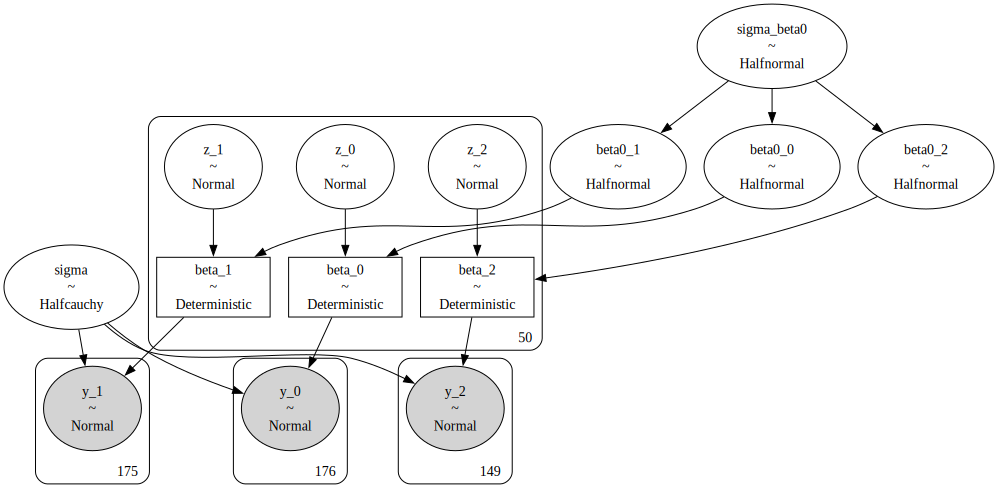

In [26]:
non_vectorized_splines_model.to_graphviz()

This version of the model has several `for` loop and list comprehensions.
Every Python iteration extends the computational graph (basically unrolling the loop), which becomes infeasible for PyMC to handle.

The use of 3 likelihood and sets of priors is otherwise fine and can make more sense in some cases.

We can improve the performance of this model by replacing the loop with vectorized operations.
We'll demonstrate first with current PyMC features, and then with dims.

### Old style vectorization


First, we'll introduce coords and {func}`~pymc.Data` to explicitly define the coordinate system, making the model's dimensionality clear and facilitating posterior analysis with labeled dimensions.

In [27]:
coords = {
    "group": range(3),
    "knots": range(n_knots),
    "obs": range(N),
}
with pm.Model(coords=coords) as vectorized_splines_model:
    x = pm.Data("x", x_np, dims="obs")
    y_obs = pm.Data("y_obs", y_obs_np, dims="obs")

    knots = pm.Data("knots", knots_np, dims="knot")

    sigma = pm.HalfCauchy("sigma", beta=1)
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=10)
    beta0 = pm.HalfNormal("beta_0", sigma=sigma_beta0, dims="group")
    z = pm.Normal("z", dims=("group", "knot"))

    delta_factors = pm.math.softmax(z, axis=-1)  # (groups, knot)
    slope_factors = 1 - pm.math.cumsum(delta_factors[:, :-1], axis=-1)  # (groups, knot-1)
    spline_slopes = pm.math.concatenate(
        [beta0[:, None], beta0[:, None] * slope_factors], axis=-1
    )  # (groups, knot-1)
    beta = pm.math.concatenate(
        [beta0[:, None], pm.math.diff(spline_slopes, axis=-1)], axis=-1
    )  # (groups, knot)

    beta = pm.Deterministic("beta", beta, dims=("group", "knot"))

    X = pm.math.maximum(0, x[:, None] - knots[None, :])  # (n, knot)
    mu = (X * beta[group_idx_np]).sum(-1)  # ((n, knots) * (n, knots)).sum(-1) = (n,)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs, dims="obs")

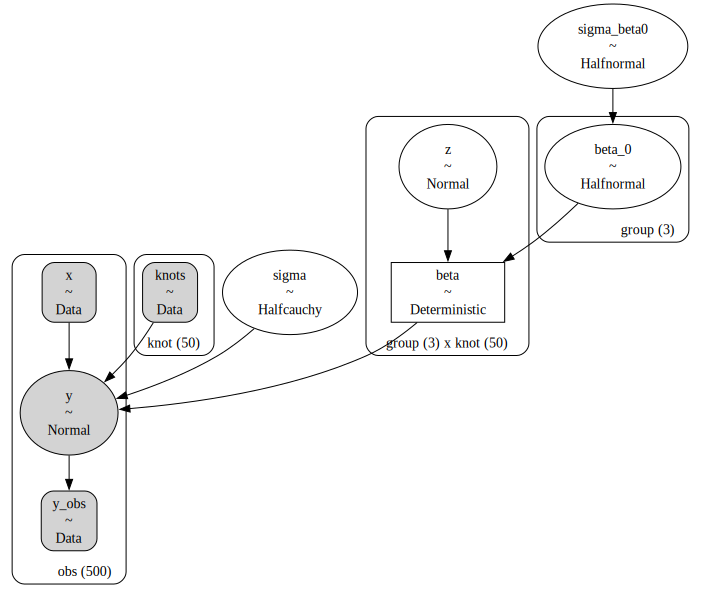

In [28]:
vectorized_splines_model.to_graphviz()

Looking only at grahpviz does not reveal much difference. The real complexity is hidden in the underlying computational graph. Let us measure it.

In [29]:
from pytensor.graph import ancestors


def count_nodes(model):
    return len({v for v in ancestors(model.basic_RVs) if v.owner})


print(f"Non-vectorized model has {count_nodes(non_vectorized_splines_model)} nodes")
print(f"Vectorized model has {count_nodes(vectorized_splines_model)} nodes")

Non-vectorized model has 806 nodes
Vectorized model has 38 nodes


This version of the model is much more succinct and performant.

However, it's considerably hard to write, specially for beginners. It requires familiarity with Numpy unusual broadcasting syntax and mental gymnastics to keep track of the dimensions.

### Vectorization with dims

Here is a version of the model using {mod}`pymc.dims`, which we hope you'll agree is more intuitive

In [30]:
with pm.Model(coords=coords) as dims_splines_model:
    x = pmd.Data("x", x_np, dims="obs")
    y_obs = pmd.Data("y_obs", y_obs_np, dims="obs")
    knots = pmd.Data("knots", knots_np, dims=("knot",))
    group_idx = pmd.math.as_xtensor(group_idx_np, dims=("obs",))

    sigma = pmd.HalfCauchy("sigma", beta=1)
    sigma_beta0 = pmd.HalfNormal("sigma_beta0", sigma=10)
    beta0 = pmd.HalfNormal("beta_0", sigma=sigma_beta0, dims=("group",))
    z = pmd.Normal("z", dims=("group", "knot"))

    delta_factors = pmd.math.softmax(z, dim="knot")
    slope_factors = 1 - delta_factors.isel(knot=slice(None, -1)).cumsum("knot")
    spline_slopes = pmd.concat([beta0, beta0 * slope_factors], dim="knot")
    beta = pmd.Deterministic("beta", pmd.concat([beta0, spline_slopes.diff("knot")], dim="knot"))

    X = pmd.math.maximum(0, x - knots)
    mu = (X * beta.isel(group=group_idx)).sum("knot")
    y = pmd.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

Let us confirm it is identical to the previous version.

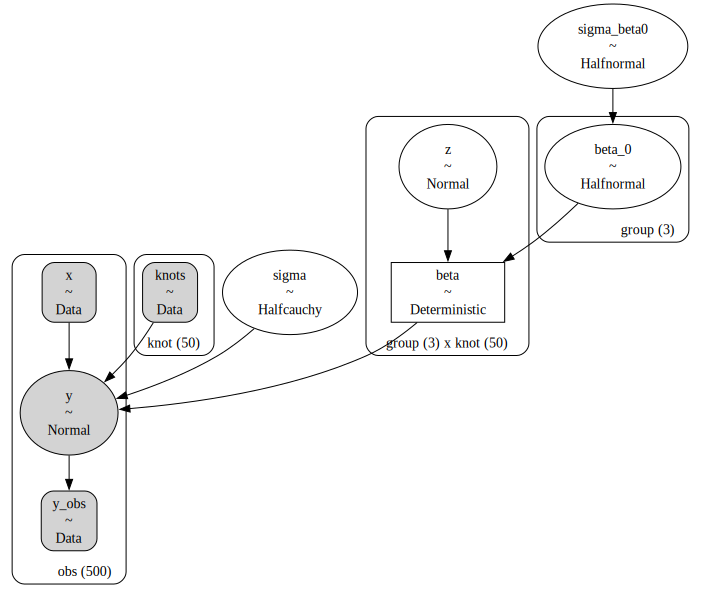

In [31]:
dims_splines_model.to_graphviz()

In [32]:
# Comment out if you want to wait a long while for the results
# non_vectorized_splines_model.point_logps()

In [33]:
vectorized_splines_model.point_logps()

{'sigma': np.float64(-1.14),
 'sigma_beta0': np.float64(-0.73),
 'beta_0': np.float64(-2.18),
 'z': np.float64(-137.84),
 'y': np.float64(-319962.47)}

In [34]:
dims_splines_model.point_logps()

{'sigma': np.float64(-1.14),
 'sigma_beta0': np.float64(-0.73),
 'beta_0': np.float64(-2.18),
 'z': np.float64(-137.84),
 'y': np.float64(-319962.47)}

We have just two more nodes in the computation graph, with no impact on performance

In [35]:
print(f"Vectorized model has {count_nodes(vectorized_splines_model)} nodes")
print(f"Vectorized model with dims has {count_nodes(dims_splines_model)} nodes")

Vectorized model has 38 nodes
Vectorized model with dims has 40 nodes


This wraps the presentation of the {mod}`pymc.dims` module. We invite you to try it out and report any problems you may find. If you wish to contribute missing functionality get involved in our [Github repository](https://github.com/pymc-devs/pymc).

## Questions and answers

### How to get xarray out of XTensorVariables?

Usually PyMC routines take care of converting outputs to Xarray for the user. 

If you want to evaluate an expression yourself you'll likely get a numpy array back. 
To convert to a {class}`~xarray.DataArray` simply reuse the `dims` attribute from the PyMC variable.

In [36]:
from xarray import DataArray

x = pm.dims.Normal.dist(dim_lengths={"a": 3})
outer_x = x + x.rename({"a": "b"})
res_numpy = pm.draw(outer_addition)
res_xr = DataArray(res_numpy, dims=outer_addition.dims)
res_xr

<xarray.DataArray (a: 3, b: 3)> Size: 72B
array([[-3.28099006, -1.57426294,  1.21146118],
       [-1.57426294,  0.13246418,  2.9181883 ],
       [ 1.21146118,  2.9181883 ,  5.70391243]])
Dimensions without coordinates: a, b

### Why aren't coordinate-based operations supported?

The new xtensor variable and operations do not propagate information about coordinates, which means you cannot perform coordinate-related operations like `sel`, `loc`, `drop`.

This limitation might be disappointing for someone used to Xarray, it is a necessary trade-off to allow PyMC to evaluate the model in a performant way.
PyMC uses PyTensor under the hood, which compiles functions to C (or numba or JAX) backends. None of these backends support dims or coordinates.
To work with these backends, PyTensor rewrites xtensor operations using equivalent tensor operations, which are pretty much abstract NumPy code. This is relatively easy to do, because it's mostly about aligning dimensions for broadcasting or indexing correctly.

Rewriting coordinate-related operations into NumPy-like code is a different matter. Many such operations don't have straightforward equivalency, they are more like querying or joining a database than performing array operations.

PyMC models will keep supporting the `coords` argument as a way to specify dimensions of model variables. But for modeling purposes, only the dimension names and their lengths play a role.

### One final note of caution on coordinates

When you provide coords to a PyMC model, they are attached to any functions that returns Xarray or InferenceData objects.

This creates a potential problem.

Suppose we have multiple arrays with the same dims but different shapes.
This is legal in PyMC, as in Xarray, and some operations, like indexing or concatenating, can handle it.

However, after sampling, PyMC tries to reattach the coordinates to any computed variables, and these might not have the right shape, or they might not be correctly aligned.

When PyMC tries to convert the results of sampling to InferenceData, it will issue a warning and refuse to propagate the original coordinates.

Here's an example where we have two variables with the `a` dim but different shapes, and only one matches the shape of the coordinates specified in the model.

In [37]:
with pm.Model(coords={"a": [-1, 0, 1]}) as m:
    x = pmd.Normal("x", dims=("a",))
    y = pmd.Deterministic("y", x.isel(a=slice(1, None)))
    assert y.dims == ("a",)

    idata = pm.sample_prior_predictive()
idata.prior["y"].coords

Sampling: [x]
/home/ricardo/Documents/pymc/pymc/backends/arviz.py:70: UserWarning: Incompatible coordinate length of 3 for dimension 'a' of variable 'y'.
This usually happens when a sliced or concatenated variable is wrapped as a `pymc.dims.Deterministic`.The originate coordinates for this dim will not be included in the returned dataset for any of the variables. Instead they will default to `np.arange(var_length)` and the shorter variables will be right-padded with nan.
To make this warning into an error set `pymc.backends.arviz.RAISE_ON_INCOMPATIBLE_COORD_LENGTHS` to `True`
  warnings.warn(


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * a        (a) int64 24B 0 1 2

One way to work around this limitation is to rename the dimensions to avoid the conflict.

In [38]:
with pm.Model(coords={"a": [-3, -2, -1], "a*": [-2, -1]}) as m:
    x = pmd.Normal("x", dims=("a",))
    y = pmd.Deterministic("y", x.isel(a=slice(1, None)).rename({"a": "a*"}))
    assert y.dims == ("a*",)
    # You can rename back to the original name if you need it for further operations
    y = y.rename({"a*": "a"})

    idata = pm.sample_prior_predictive(draws=1)
idata.prior["y"].coords

Sampling: [x]


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a*       (a*) int64 16B -2 -1

An alternative is to manually specify the coordinates after sampling.

Note that when doing advanced indexing the name of the indexed dimension can be controlled by the name of the indexing xtensor

In [39]:
x.isel(a=pmd.math.as_xtensor([0, 1, 2], dims=("a*",))).dims

('a*',)

However, silent bugs can still happen if the shapes are compatible but the coordinates are not correct.
For example, in this model the coordinates are reversed, but the shape matches, so the error is not detected.

In [40]:
with pm.Model(coords={"a": [1, 2, 3]}):
    x = pmd.Normal("x", dims=("a",))
    pmd.Deterministic("x_reversed", x[::-1])
    idata = pm.sample_prior_predictive(draws=1)
(idata.prior["x"] - idata.prior["x_reversed"]).values

Sampling: [x]


array([[[-1.53640397,  0.        ,  1.53640397]]])

In Xarray the results would be correct because it is aware of the coordinates, not just the shape.

In [41]:
(idata.prior["x"] - idata.prior["x"].isel(a=slice(None, None, -1))).values

array([[[0., 0., 0.]]])

Is not a new problem with the {mod}`pymc.dims` module; it is a consequence of PyMC's inability to reason about coords symbolically.
But this kind of error is made more likely because functions from the {mod}`pymc.dims` module always propagate dimension names to the model object.

We remind users that {func}`pymc.dims.Deterministic` variables are never required in a model; they are just a way to calculate and store the results of intermediate operations. If you use them, pay extra attention as to whether the model coordinates are appropriate for the variable stored in the  {func}`pymc.dims.Deterministic` (and not just their length but ordering as well).

Alternatively, you can use the regular {func}`pymc.Deterministic` without specifying `dims`, which will not propagate the coordinates to the model. Keep in mind that the respective dimensions will be considered unique after sampling, and operations between variables that had shared dims in the original model will broadcast orthogonally in the returned InferenceData variables.

If you need variables to have the same dims but different coords, you can always fix them manually.

In [42]:
idata.prior["x_reversed"] = idata.prior["x_reversed"].assign_coords({"a": [3, 2, 1]})
idata.prior["x"] - idata.prior["x_reversed"]

<xarray.DataArray (chain: 1, draw: 1, a: 3)> Size: 24B
array([[[0., 0., 0.]]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a        (a) int64 24B 1 2 3